In [3]:
# Imports
from credentials import mail, password
from pymongo import MongoClient
import gridfs

import requests
import random
from io import BytesIO

from time import sleep
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from pprint import pprint
import matplotlib.pyplot as plt
from PIL import Image
from bson import Regex
import time


'Logging in to facebook ...'
'DataBase getting ready ...'
'Preparation done ! :)'
'Looking for results for sentence le décès du président Jacques Chirac'
'Searching for posts ...'
'Looking for images ...'
'Got all images !'
'Everything is done ! :)'
'Validation step of the MongoDB database content ...'
{'_id': ObjectId('60e0ed5530694e08da88f8dc'),
 'text': 'C’est dans l’avion de retour de Rodez que j’ai appris le décès du '
         'président Jacques Chirac.\n'
         'Il aimait ce département de l’Aveyron, comme il aimait tous les '
         'départements ruraux, dont il avait la force et la simplicité.\n'
         'J’avais 29 ans quand j’ai commencé à travailler à ses côtés et, au '
         'moment si triste de sa mort, les souvenirs se bousculent.\n'
         'Pourquoi, comme tant de Français, ai-je aimé Jacques Chirac ?\n'
         'Je l’ai aimé pour ses mots lors de mon premier Salon de '
         'l’Agriculture en 2009 quand, pressé de questions par les '
         'journalist

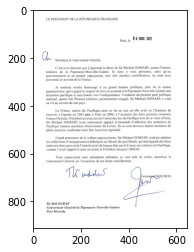

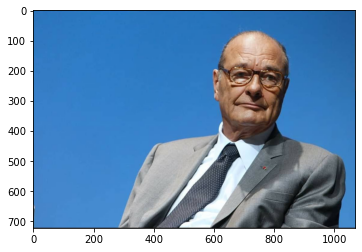

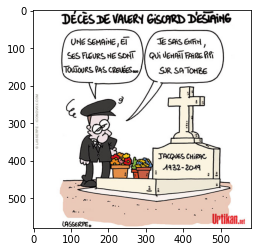

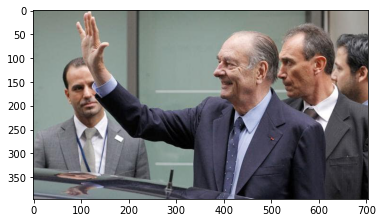

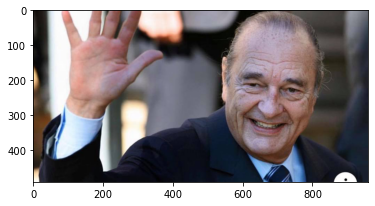

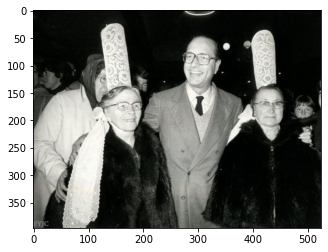

Validation done !


In [4]:
# Pages pertinentes 
logging_page = "https://www.facebook.com/"
search_all_content = "https://www.facebook.com/search/top?q="
search_only_posts ="https://www.facebook.com/search/posts/?q="
search_only_images = "https://www.facebook.com/search/photos?q="

# Examples de posts pour les tets
posts_examples = [
    "https://www.facebook.com/blm27/posts/2633081830089213",
    "https://www.facebook.com/RadioDisneyClubFr/posts/10157564835759776",
    "https://www.facebook.com/permalink.php?story_fbid=2213124715481673&id=301800386614125",                  
]

# Phrase à rechercher
sentence = "le décès du président Jacques Chirac"

class Crawler:
    def __init__(self, mail ,password):
        """
        Initialisation de la classe de Crawler effectuant le scrapping des posts et images.
        Création du webdriver et lancement de l'initialisation de base de données.
        Input :
            mail : Email pour se connecter à facebook.
            password : Mot-de-passe associé.
        """
        options = webdriver.FirefoxOptions()
        options.set_preference("dom.push.enabled", False)
        options.headless = False
        options.binary_location = r'C:\Users\Ray\AppData\Local\Mozilla Firefox\firefox.exe'
        self.driver = webdriver.Firefox(options=options, executable_path=r'geckodriver.exe')
        self.mail = mail
        self.password = password
        self.login()
        
        time.sleep(5)
        self.init_db()
        pprint("Preparation done ! :)")
    
    
    def init_db(self):
        """
        Initialise MongoDB et GridFS et ses différentes collections.
        """
        pprint("DataBase getting ready ...")
        self.client = MongoClient('localhost',27017)
        self.posts = self.client.scrapper.posts
        self.images = gridfs.GridFS(self.client.scrapper, "images")
    
    def login(self):
        """
        Connexion à Facebook avec les identifiants.
        """
        pprint("Logging in to facebook ...")
        self.driver.get(logging_page)
        sleep(2)

        email_input = self.driver.find_element_by_name("email")
        email_input.send_keys(self.mail)

        password_input = self.driver.find_element_by_name("pass")
        password_input.send_keys(self.password)
        password_input.submit()
        sleep(2)

    def search_posts(self, sentence, store=False):
        """
        Fonction pour extraire et stocker les posts liés à une phrase.
        Input:
            sentence : Phrase à rechercher.
            store : Booléen définissant si on doit stocker dans MongoDB les résultats.
        """
        pprint("Searching for posts ...")
        search_link = search_only_posts+str(sentence)
        self.driver.get(search_link)
        n_scrolls = 20
        keep = ["posts", "top"] 
        for n_scroll in range(n_scrolls):
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(5)
        
        links = self.driver.find_elements_by_tag_name('a')
        links = [a.get_attribute('href') for a in links ]
        links = [a for a in links if (any(k in str(a) for k in keep) and "search" not in str(a) and len(str(a))>30)]
        for link in links:
            post = {}
            self.driver.get(link)
            time.sleep(5)
            content = self.driver.find_elements_by_css_selector('.d2edcug0.hpfvmrgz.qv66sw1b.c1et5uql.lr9zc1uh.a8c37x1j.keod5gw0.nxhoafnm.aigsh9s9.d3f4x2em.fe6kdd0r.mau55g9w.c8b282yb.iv3no6db.jq4qci2q.a3bd9o3v.knj5qynh.oo9gr5id.hzawbc8m')
            post["url"] = link
            post["text"] = content[0].text 
            if store:   self.posts.insert_one(post)
        
    
    def search_images(self, sentence, store=False):
        """
        Fonction pour extraire et stocker les posts liés à une phrase.
        Input:
            sentence : Phrase à rechercher.
            store : Booléen définissant si on doit stocker dans GridFS les images.
        """
        n_scrolls = 20
        pprint("Looking for images ...")
        search_link = search_only_images+str(sentence)
        self.driver.get(search_link)
        keep = ["photos"]
        for n_scroll in range(n_scrolls):
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(5)
        
        links = self.driver.find_elements_by_tag_name('a')
        links = [a.get_attribute('href') for a in links ]
        links = [a for a in links if (any(k in str(a) for k in keep) and "search" not in str(a) and len(str(a))>40)]
        
        for link in links:
            self.driver.get(link)
            time.sleep(5)
            content = self.driver.find_elements_by_css_selector('.gitj76qy.r9f5tntg.d2edcug0.r0294ipz')
            img = content[0].get_attribute('src')
            response = requests.get(img, stream=True)
            if store:   self.images.put(response.content, filename="Image__"+str(links.index(link)))
        pprint("Got all images !")
        pprint("Everything is done ! :)")

    def search(self, sentence, store=False):
        """
        Fonction de recherche de phrase.
        Input:
            sentence : Phrase à rechercher.
            store : Booléen définissant si on doit stocker dans GridFS+MongoDB le contenu.
        """
        pprint("Looking for results for sentence "+str(sentence))
        self.posts.delete_many({})
        for i in self.images.find():    self.images.delete(i._id)
        self.search_posts(sentence, store=store)
        self.search_images(sentence, store=store)

    def validation(self):
        """
        Fonction de validation pour afficher le contenu de la base de données, que ce soit les posts ou les images.
        """
        pprint("Validation step of the MongoDB database content ...")
        cursor = self.posts.find({})
        for post in cursor: pprint(post)
         
        for file in self.images.find({'filename': Regex(r'Image__*')}):
            img =  BytesIO(file.read())
            plt.figure()
            to_plot = Image.open(img)
            plt.imshow(to_plot)
            plt.show()
        
        print("Validation done !")
    
explorer = Crawler(mail, password)
explorer.search(sentence, store=True)
explorer.validation()